In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from core.utils import  solve_path, list_files, solve_dir, list_files_recursive 

/home/h-pgy/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
OG_DATA_FOLDER = solve_path('dados_crime', parent='original_data')
GEN_DATA_FOLDER = solve_dir('generated_data')

In [3]:
def build_df_dados_originais(folder=OG_DATA_FOLDER):
    
    xlsx = list_files(folder, extension='xlsx')
    dfs = []
    for f in xlsx:
        temp_df = pd.read_excel(f)
        dfs.append(temp_df)
        
    return pd.concat(dfs)

In [4]:
def save_csv(df, fname, gen_data_folder=GEN_DATA_FOLDER):
    
    path_destino = solve_path(solve_path(fname, gen_data_folder))
    df.to_csv(path_destino, sep=';', encoding='latin-1', index=False)

In [5]:
def get_df_dados_originais(gen_data_folder = GEN_DATA_FOLDER, 
                           og_folder = OG_DATA_FOLDER):
    
    folder_destino = solve_dir(solve_path('dados_originais', gen_data_folder))
    files = list_files(folder_destino, 'csv')
    
    if files:
        print('Abrindo dados já salvos')
        return pd.read_csv(files[0], sep=';', encoding='latin-1')
    
    df = build_df_dados_originais(og_folder)
    save_csv(df, 'df_crimes.csv', folder_destino)
    return df

In [6]:
from core.download_data import (DownloadShpsGeoSampa,
                                DadosSetoresCensoDownload,
                               )

In [7]:
def download_control_data():
    
    geosampa = DownloadShpsGeoSampa()
    censo = DadosSetoresCensoDownload()    
    geosampa()
    censo()


In [8]:
download_control_data()

Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/setores_censitarios já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/estacoes_metro já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/estacoes_cptm já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/zonas_OD_2017 já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/equipamentos_culturais já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/equipamentos_saude já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/equipamentos_educacao já salvo
Shape /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files/parques_municipais já salvo
File /home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/censo_2010/microdados_censo.zip saved

In [9]:
df = get_df_dados_originais()

Abrindo dados já salvos


In [10]:
df.sample(5)

,ID_DELEGAC,ANO_BO,NUM_BO,DELEGACIA,DATA_OCORR,HORA_OCORR,RUBRICA,LATITUDE,LONGITUDE,sp_codigo,sp_areakmt,sp_id,sp_areamt,sp_nome
12558,900020,2021,346376,53,10/12/2020,10:00,Furto,-23.580451,-46.488245,27,55.091,11,55090525.66,ITAQUERA
8450,900020,2021,1029250,66,10/06/2021,22:00,Furto,-23.560835,-46.480761,27,55.091,11,55090525.66,ITAQUERA
12034,900020,2021,639043,53,12/04/2021,00:00,Furto,-23.565891,-46.474453,27,55.091,11,55090525.66,ITAQUERA
4848,10329,2018,4730,66,14/12/2018,07:30,Furto,-23.567236,-46.492788,27,55.091,11,55090525.66,ITAQUERA
7447,10329,2018,669,66,14/02/2018,17:00,Roubo,-23.553043,-46.510849,27,55.091,11,55090525.66,ITAQUERA


In [11]:
len(df)

40424

## Verificando dados duplicados

In [12]:
df.keys()

Index(['ID_DELEGAC', 'ANO_BO', 'NUM_BO', 'DELEGACIA', 'DATA_OCORR',
       'HORA_OCORR', 'RUBRICA', 'LATITUDE', 'LONGITUDE', 'sp_codigo',
       'sp_areakmt', 'sp_id', 'sp_areamt', 'sp_nome'],
      dtype='object')

In [13]:
df['NUM_BO'].duplicated().sum()

11404

In [14]:
df['NUM_BO'].duplicated().sum()/len(df)

0.2821096378389076

### Criando ID

OS BOs não são unificados: os números são por delegacia e por ano.

Aqui nós criamos esse ID.

In [15]:
df['id_bo'] = df['ID_DELEGAC'].astype(str) + '/' + df['ANO_BO'].astype(str) + '.'+ df['NUM_BO'].astype(str)

In [16]:
df['id_bo'].sample(3)

24945     900020/2020.448888
21449        10326/2017.8572
33867    900020/2019.1088734
Name: id_bo, dtype: object

Vê-se que não há mais duplicatas.

In [17]:
df['id_bo'].duplicated().sum().any()

False

Selecionando variáveis de interesse

In [18]:
df.keys()

Index(['ID_DELEGAC', 'ANO_BO', 'NUM_BO', 'DELEGACIA', 'DATA_OCORR',
       'HORA_OCORR', 'RUBRICA', 'LATITUDE', 'LONGITUDE', 'sp_codigo',
       'sp_areakmt', 'sp_id', 'sp_areamt', 'sp_nome', 'id_bo'],
      dtype='object')

Os dados que começam com sp_ são do join com as subprefeituras da cidade.
Selecionaram apenas Itaquera. Por isso a área é uma só também - é a área de Itaquera.

In [19]:
df['sp_nome'].unique()

array(['ITAQUERA'], dtype=object)

In [20]:
df['sp_areamt'].unique()

array([55090525.66])

In [21]:
interesse = [
    'id_bo', # id
    'ANO_BO', #sazonalidade
    'DATA_OCORR', #sazonalidade
    'RUBRICA', #tipo de crime
    'LATITUDE', #lat
    'LONGITUDE', #long
]

In [22]:
df = df[interesse].copy()

In [23]:
rename = {col : col.lower()
         for col in df.columns}

df.rename(rename, axis=1, inplace=True)

In [24]:
df.head(2)

,id_bo,ano_bo,data_ocorr,rubrica,latitude,longitude
0,20301/2018.3689,2018,15/11/2018,Roubo,-23.540862,-46.431623
1,10329/2018.122,2018,07/01/2018,Roubo,-23.555904,-46.503096


In [25]:
df.dtypes

id_bo          object
ano_bo          int64
data_ocorr     object
rubrica        object
latitude      float64
longitude     float64
dtype: object

In [26]:
df['data_ocorr'] = pd.to_datetime(df['data_ocorr'], 
                                  format="%d/%m/%Y",errors='coerce')

Menos de 0,013% por cento de dados com data errada (apenas 5).

Vamos exclui-los.

In [27]:
df['data_ocorr'].isnull().mean()

0.00012368889768454383

In [28]:
df['data_ocorr'].isnull().sum()

5

In [29]:
df = df[df['data_ocorr'].notnull()].copy().reset_index(drop=True)

In [30]:
df.dtypes

id_bo                 object
ano_bo                 int64
data_ocorr    datetime64[ns]
rubrica               object
latitude             float64
longitude            float64
dtype: object

In [31]:
df = gpd.GeoDataFrame(df, crs='epsg:4326',
                      geometry=gpd.points_from_xy(df.longitude, df.latitude))

<AxesSubplot:>

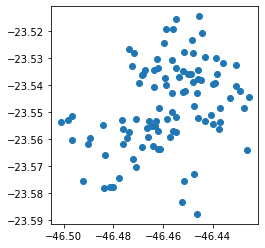

In [32]:
df.sample(100).plot()

# Agrupando por setor censitário

Nossa variável dependente será a quantidade de ocorrências por tipo (furto ou roubo) por setor censitário na subprefeitura de Itaquera.

In [33]:
SHP_PATH = solve_path('shp_files', 'original_data')

In [34]:
SHP_PATH

'/home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/shp_files'

## Setores censitarios

In [35]:
shp_censo = solve_path('setores_censitarios', SHP_PATH)

shp_censo = gpd.read_file(solve_path(shp_censo))

In [36]:
shp_censo.head()

,ID,AREA_M,CODSETOR,TIPO,POPULACAO,IPVS_V10,geometry
0,1,311095.19,355030803000062,URBANO,NaN,NaN,"POLYGON ((313583.671 7410283.926, 313590.067 7..."
1,2,49953.56,355030803000069,RURAL,NaN,NaN,"POLYGON ((313583.671 7410283.926, 313626.775 7..."
2,3,238621.26,355030803000063,RURAL,NaN,NaN,"POLYGON ((313580.989 7410657.604, 313604.792 7..."
3,4,6912969.36,355030803000049,RURAL,32.0,0.0,"POLYGON ((314069.929 7411007.142, 314082.787 7..."
4,5,81244.42,355030803000072,RURAL,NaN,NaN,"POLYGON ((317840.068 7410696.348, 317839.385 7..."


In [37]:
shp_censo.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
shp_censo['CODSETOR'].duplicated().any()

False

In [39]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
df = df.to_crs(epsg=31983)

In [41]:
df.crs.name == shp_censo.crs.name


True

In [42]:
df = df.sjoin(shp_censo, how='left', predicate='intersects')

Conseguimos um join perfeito!

In [43]:
df['index_right'].isnull().any()

False

In [44]:
df['id_bo'].duplicated().any()

False

Nossa unidade de observação será os setores censitários.

Então vamos agrupar os dados.

In [45]:
df.keys()

Index(['id_bo', 'ano_bo', 'data_ocorr', 'rubrica', 'latitude', 'longitude',
       'geometry', 'index_right', 'ID', 'AREA_M', 'CODSETOR', 'TIPO',
       'POPULACAO', 'IPVS_V10'],
      dtype='object')

In [46]:
df = df.groupby(['CODSETOR', 'ano_bo', 'rubrica'])[['id_bo']].count().reset_index()

In [47]:
df.rename({'id_bo' : 'qtd_ocorr',
           'CODSETOR' : 'cod_setor'}, axis=1, inplace=True)

In [48]:
df['cod_setor'] = df['cod_setor'].astype(str)

In [49]:
df.sample(5)

,cod_setor,ano_bo,rubrica,qtd_ocorr
2744,355030837000126,2021,Roubo,12
2482,355030837000097,2019,Furto,8
638,355030824000064,2019,Roubo,9
6353,355030891000040,2021,Roubo,2
707,355030824000071,2019,Furto,12


In [50]:
save_csv(df, 'ocorrencias_por_setor.csv')

Agora a gente acrescenta as variáveis do setor censitário de volta no dataframe

In [51]:
cols_setor = {
            'CODSETOR' : 'cod_setor',
            'AREA_M' : 'setor_area',
            'TIPO' : 'setor_tipo', 
            'POPULACAO' : 'setor_pop',
            'IPVS_V10' : 'setor_ipvs'
             }

In [52]:
dados_setor = shp_censo[cols_setor.keys()].copy()

In [53]:
dados_setor.rename(cols_setor, axis=1, inplace=True)

In [54]:
dados_setor.head(3)

,cod_setor,setor_area,setor_tipo,setor_pop,setor_ipvs
0,355030803000062,311095.19,URBANO,NaN,NaN
1,355030803000069,49953.56,RURAL,NaN,NaN
2,355030803000063,238621.26,RURAL,NaN,NaN


In [55]:
dados_setor['cod_setor'] = dados_setor['cod_setor'].astype(str)

In [56]:
df = pd.merge(df, dados_setor, how='left', on = 'cod_setor')

In [57]:
df.sample(3)

,cod_setor,ano_bo,rubrica,qtd_ocorr,setor_area,setor_tipo,setor_pop,setor_ipvs
160,355030824000012,2017,Furto,1,37135.56,URBANO,761.0,2.0
4529,355030847000048,2020,Roubo,3,29441.14,URBANO,685.0,4.0
2754,355030837000127,2021,Roubo,6,73364.26,URBANO,1402.0,3.0


# Merge dados de controle

Os dados de controle também são dados geoespaciais.

Para isso, vamos calcular o centroide dos setores, assim conseguimos calcular mais facilmente a distância deles em relação aos objetos de controle.

In [58]:
shp_censo['centroid'] = shp_censo.centroid

In [59]:
centroid_setor = shp_censo[['CODSETOR', 'centroid']].copy()
centroid_setor.rename({'CODSETOR' : 'cod_setor',
                      'centroid' : 'geometry'}, axis=1, inplace=True)

In [60]:
centroid_setor.head(2)

,cod_setor,geometry
0,355030803000062,POINT (313911.106 7410252.886)
1,355030803000069,POINT (313548.071 7410109.963)


In [61]:
df = pd.merge(df, centroid_setor, how='left', on='cod_setor')

In [62]:
df.head(2)

,cod_setor,ano_bo,rubrica,qtd_ocorr,setor_area,setor_tipo,setor_pop,setor_ipvs,geometry
0,355030805000091,2018,Roubo,1,57989.7,URBANO,931.0,2.0,POINT (348852.704 7394619.119)
1,355030805000091,2021,Roubo,1,57989.7,URBANO,931.0,2.0,POINT (348852.704 7394619.119)


Mas precisamos definir o crs novamente

In [63]:
df.crs

In [64]:
df = df.set_crs(epsg=31983)

## Distância metrô

In [65]:
folder_metro = solve_path('estacoes_metro', SHP_PATH)
shp_metro = solve_path('SIRGAS_SHP_estacaometro', folder_metro)
shp_metro = gpd.read_file(solve_path(shp_metro))

<AxesSubplot:>

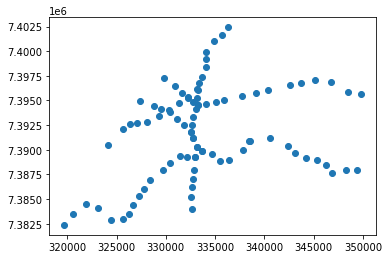

In [66]:
shp_metro.plot()

In [67]:
shp_metro['emt_situac'].unique()

array(['OPERANDO'], dtype=object)

In [68]:
shp_metro = shp_metro.set_crs(epsg=31983)

In [69]:
shp_metro.crs.name == df.crs.name

True

In [70]:
def build_distance_matrix(df, other):
    
    distancias = []
    for i, row in other.iterrows():

        location = row['geometry']
        distancias.append(df['geometry'].distance(location))
        
    return np.matrix(distancias)

In [71]:
def smallest_distance(df, other):
    
    distance_matrix = build_distance_matrix(df, other)
    
    smallest_dist_matrix = np.min(distance_matrix.T, axis=1)
    
    #tem que extrair os itens para ficar uma dimensao soh
    return [i.item() for i in np.ravel(smallest_dist_matrix)]

In [72]:
menor_dist_metro = smallest_distance(df, shp_metro)

In [73]:
len(menor_dist_metro) == len(df)

True

In [74]:
df['menor_dist_metro'] = menor_dist_metro

### Testando se a função funcionou

In [75]:
setor_teste = df.loc[0, 'cod_setor']
lat_long_teste = shp_censo[shp_censo['CODSETOR']==setor_teste].centroid.to_crs(epsg=4326)
lat_long_teste

17785    POINT (-46.48085 -23.55175)
dtype: geometry

In [76]:
dist_calc = df.loc[0, 'menor_dist_metro']

In [77]:
dist_calc

1325.3129481772403

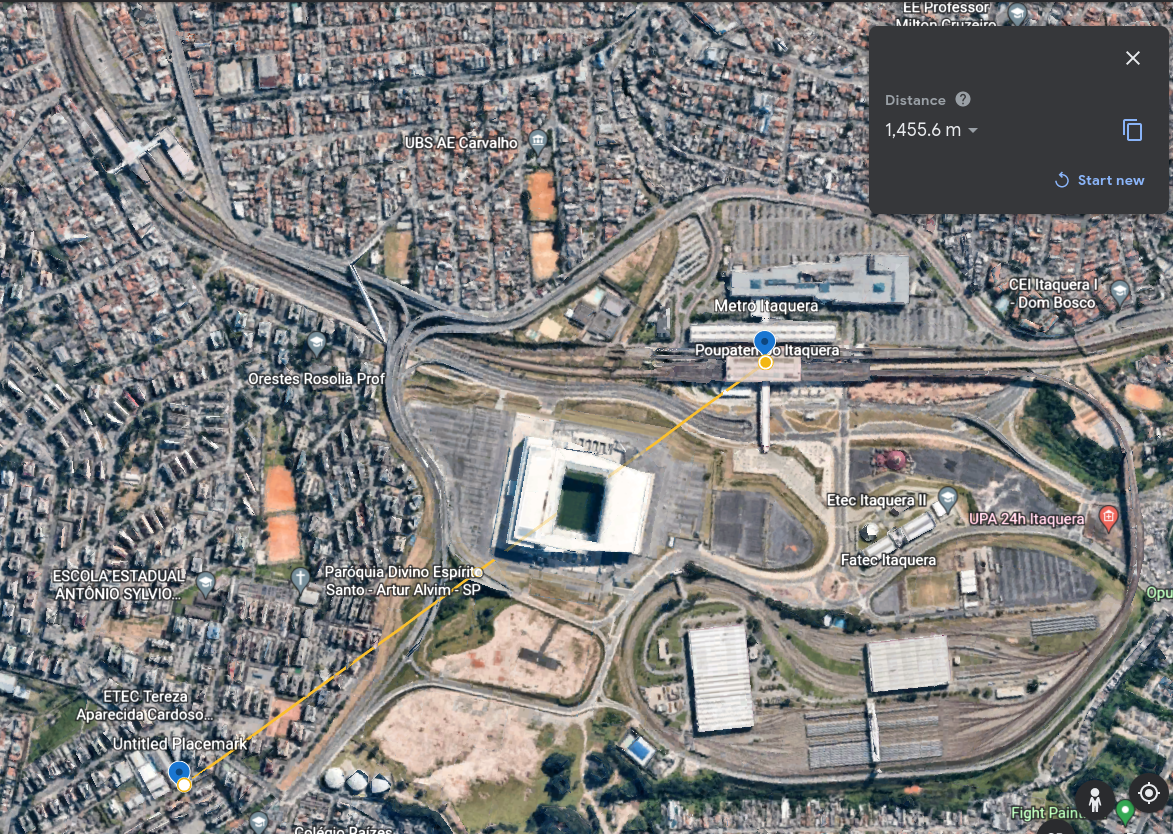

In [78]:
from IPython.display import Image
Image(filename='teste_calculo_distancia.png') 

A pequena divergência provavelmente se deu pela diferença de projeções (SIRGAS 2000 e WGS84). Note que há um erro de precisão ao convertermos o centroid do poligono do setor censitario para WGS84. Fora que não há garantia que o ponto (lat long) de definição da estação de metrô do google é o mesmo definido pela Prefeitura na base do GeoSampa.

## Distância trem

In [79]:
folder_trem = solve_path('estacoes_cptm', SHP_PATH)
shp_trem = solve_path('SIRGAS_SHP_estacaotrem', folder_trem)
shp_trem = gpd.read_file(solve_path(shp_trem))

<AxesSubplot:>

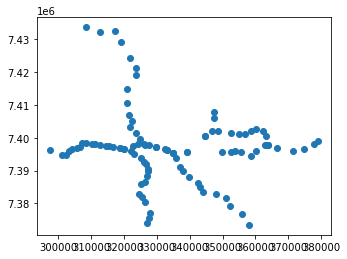

In [80]:
shp_trem.plot()

In [81]:
shp_trem.head(2)

,etr_situac,etr_linha,etr_nome,etr_empres,geometry
0,OPERANDO,DIAMANTE,PARADA AMADOR BUENO,CPTM,POINT (297477.101 7396351.054)
1,OPERANDO,RUBI,JUNDIAÍ,CPTM,POINT (308378.796 7433640.756)


In [82]:
menor_dist_trem = smallest_distance(df, shp_trem)

In [83]:
df['menor_dist_trem'] = menor_dist_trem

In [84]:
df.sample(2)

,cod_setor,ano_bo,rubrica,qtd_ocorr,setor_area,setor_tipo,setor_pop,setor_ipvs,geometry,menor_dist_metro,menor_dist_trem
4044,355030837000273,2021,Furto,3,9216.14,URBANO,364.0,3.0,POINT (351689.417 7394681.555),2099.919272,1232.713957
1085,355030824000113,2018,Roubo,9,40510.36,URBANO,610.0,2.0,POINT (345556.962 7394226.543),2868.990811,4522.867129


### Próximo a parques

In [85]:
folder_parques = solve_path('parques_municipais', SHP_PATH)
shp_parques = solve_path('SIRGAS_SHP_parquemunicipal', folder_parques)
shp_parques = gpd.read_file(solve_path(shp_parques))

In [86]:
shp_parques.sample(3)

,pq_area,pq_id,pq_nome,pq_PrefReg,geometry
158,216041.4,158,Zilda Arns Neumann,Sapopemba,"POLYGON ((347886.723 7388397.231, 347883.353 7..."
176,103255.1,176,Corrego Agua Vermelha,Itaim Paulista,"POLYGON ((355271.192 7400729.711, 355281.518 7..."
96,33170.48,96,Raul Seixas,Itaquera,"POLYGON ((352517.903 7394608.281, 352518.101 7..."


In [87]:
shp_parques = shp_parques.set_crs(epsg=31983)

In [88]:
shp_parques.crs.name == df.crs.name

True

In [89]:
#é 500 metros porque a unidade de medida da projecao é metros
shp_parques['geometry'] = shp_parques.buffer(500)

In [90]:
prox_parque = df.sjoin(shp_parques, how='left', predicate='within')[['cod_setor', 'pq_nome']]

In [91]:
del shp_parques

In [92]:
prox_parque = prox_parque.reset_index(drop=True)

Apenas 13% dos registros estão proximos de um parque

In [93]:
prox_parque['pq_nome'].notnull().mean()

0.13839425179631365

In [94]:
prox_parque['cod_setor'].duplicated().sum()

5654

In [95]:
prox_parque[prox_parque['pq_nome'].notnull()].sample(5)

,cod_setor,pq_nome
6245,355030857000079,Carmo - Olavo Egidio Setubal
2455,355030837000091,Rio Verde
286,355030824000024,Savoy City
57,355030824000001,Savoy City
545,355030824000049,Nair Bello


Os nomes dos parques fazem sentido - são parques da região de fato

In [96]:
prox_parque['pq_nome'].unique()

array([nan, 'Savoy City', 'Nair Bello', 'Guaratiba', 'Rio Verde',
       'Raul Seixas', 'Carmo - Olavo Egidio Setubal'], dtype=object)

Mas queremos saber apenas se o setor está proximo de um parque, sim ou não, não de quais parques está perto

In [97]:
setores_prox_parque = prox_parque[prox_parque['pq_nome'].notnull()]['cod_setor'].unique()

In [98]:
setores_prox_parque[:3]

array(['355030824000001', '355030824000006', '355030824000007'],
      dtype=object)

In [99]:
df['a_500m_parque'] = df['cod_setor'].isin(setores_prox_parque)

In [100]:
df['a_500m_parque'].mean()

0.13433772755806653

In [101]:
folder_saude = solve_path('equipamentos_saude', SHP_PATH)
shps_saude = solve_path('EQUIPAMENTOS_SHP_TEMA_SAUDE', folder_saude)

In [102]:
shps_saude = [solve_path(f, shps_saude) for f in 
               os.listdir(shps_saude) if f.endswith('.shp')]

In [103]:
shps = []
for shp in shps_saude:
    geodf = gpd.read_file(shp)
    shps.append(geodf)
    
shp_saude = pd.concat(shps)

In [104]:
shp_saude.crs

In [105]:
shp_saude = shp_saude.set_crs(epsg = 31983)

In [106]:
shp_saude.head()

,eq_cnes,eq_enderec,eq_nome,eq_bairro,eq_cep,eq_setcens,eq_ar_pond,eq_cd_dist,eq_distr,eq_cd_subp,...,eq_telefon,eq_cd_esfe,eq_esfera,eq_cd_tipo,eq_tipo,eq_classe,eq_leitos,eq_cd_clas,eq_id,geometry
0,2027089,"AV. ITABERABA,1377",LABORATÓRIO MUNICIPAL NSA SRA DO O,FREGUESIA DO Ó,02734000\n,355030829000013,3550308005117,29,FREGUESIA DO O,3,...,3975-069,01,Municipal,058,LAB,OUTROS_ESTABELECIMENTOS_E_SERVICOS_ESPECIALIZADOS,None,9,1072,POINT (326996.041 7401252.214)
1,2027097,"R. PADRE MARCHETTI,557",LABORATÓRIO MUNICIPAL DA REGIÃO SUDESTE,IPIRANGA,04266000\n,355030834000009,3550308005043,34,IPIRANGA,13,...,2063-076,01,Municipal,058,LAB,OUTROS_ESTABELECIMENTOS_E_SERVICOS_ESPECIALIZADOS,None,9,1073,POINT (335920.758 7390487.633)
2,2091674,"R. PAULA CRUZ,71",LABORATÓRIO DE SANTO AMARO,JD DOM BOSCO,04757120\n,355030871000065,3550308005174,71,SANTO AMARO,14,...,5548-796,01,Municipal,058,LAB,OUTROS_ESTABELECIMENTOS_E_SERVICOS_ESPECIALIZADOS,None,9,1076,POINT (325009.115 7383401.459)
3,2091771,"AV. MARIA SANTANA,101",LABORATÓRIO DE SÃO MIGUEL PAULISTA,SAO MIGUEL PAULISTA,08040300\n,355030887000046,3550308005193,87,VILA JACUI,23,...,2057-570,01,Municipal,058,LAB,OUTROS_ESTABELECIMENTOS_E_SERVICOS_ESPECIALIZADOS,None,9,1077,POINT (351382.313 7399193.363)
4,2752085,"AV. QUEIROZ FILHO,313",LABORATÓRIO MUNICIPAL LAPA,PQ DA LAPA,05319000\n,355030802000062,3550308005106,2,ALTO DE PINHEIROS,11,...,3021-217,01,Municipal,058,LAB,OUTROS_ESTABELECIMENTOS_E_SERVICOS_ESPECIALIZADOS,None,9,1078,POINT (324204.753 7395943.342)


In [107]:
shp_saude.keys()

Index(['eq_cnes', 'eq_enderec', 'eq_nome', 'eq_bairro', 'eq_cep', 'eq_setcens',
       'eq_ar_pond', 'eq_cd_dist', 'eq_distr', 'eq_cd_subp', 'eq_subpref',
       'eq_regiao5', 'eq_regiao8', 'eq_telefon', 'eq_cd_esfe', 'eq_esfera',
       'eq_cd_tipo', 'eq_tipo', 'eq_classe', 'eq_leitos', 'eq_cd_clas',
       'eq_id', 'geometry'],
      dtype='object')

In [108]:
tipos_hospital = [tipo for tipo in shp_saude['eq_tipo'].unique()
                    if 'HOSP' in tipo]

In [109]:
tipos_hospital

['HOSPITAL',
 'HOSPITAL ESPECIALIZADO',
 'HOSPITAL GERAL',
 'HOSPITAL/DIA - ISOLADO',
 'HOSP_SMS',
 'HOSPITAL/DIA - ISOLA']

In [110]:
shp_saude = shp_saude[shp_saude['eq_tipo'].isin(tipos_hospital)].copy()

In [111]:
shp_saude['eq_cnes'].duplicated().sum()

224

In [112]:
shp_saude.drop_duplicates('eq_cnes', inplace=True)

In [113]:
shp_saude.drop_duplicates('geometry', inplace=True)

In [114]:
shp_saude['eq_nome'].sample(5).unique()

array(['HOSPITAL MUNICIPAL BRASILANDIA',
       'CARMINO CARICCHIO, DR - HOSP TATUAPE', 'HOSP METROPOLITANO',
       'HOSP E MAT JARDINS', 'V NOVA CACHOEIRINHA-HOSP'], dtype=object)

In [115]:
shp_saude['eq_id'].isnull().any()

False

In [116]:
shp_saude['geometry'] = shp_saude['geometry'].buffer(500)

In [117]:
shp_saude['geometry'].duplicated().any()

False

In [118]:
prox_hosp = df.sjoin(shp_saude, how='left', predicate='within')

In [119]:
del shp_saude

In [120]:
prox_hosp['cod_setor'].duplicated().sum()

5624

In [121]:
prox_hosp.drop_duplicates('cod_setor', inplace=True)

Apenas 4% dos setores estão próximos de hospitais

In [122]:
prox_hosp['eq_id'].notnull().mean()

0.04679144385026738

In [123]:
setores_prox_hosp = prox_hosp[prox_hosp['eq_id'].notnull()]['cod_setor'].unique()

In [124]:
df['a_500m_hosp'] = df['cod_setor'].isin(setores_prox_hosp)

### Próximo a escolas

In [125]:
folder_edu = solve_path('equipamentos_educacao', SHP_PATH)
shps_edu = solve_path('EQUIPAMENTOS_SHP_TEMA_EDUCACAO', folder_edu)

In [126]:
shps_edu = [solve_path(f, shps_edu) for f in 
               os.listdir(shps_edu) if f.endswith('.shp')]

In [127]:
shps = []
for shp in shps_edu:
    geodf = gpd.read_file(shp)
    shps.append(geodf)
    
shp_edu = pd.concat(shps)

In [128]:
del shps

In [129]:
shp_edu.sample(3)

,eq_id,eq_nome,eq_enderec,eq_bairro,eq_cep,eq_tipo,eq_classe,eq_telefon,eq_setor,eq_areap,...,eq_dre,eq_cd_zona,eq_zona,eq_cd_mec,eq_esfera,eq_cd_catg,eq_categor,eq_eol,eq_horario,geometry
2096,6792,TUTOR SCHOOL SISTEMA DE ENSINO,PAULO OROZIMBO 973,CAMBUCI,1535000.0,EP,REDE_PRIVADA,1150812111 / 1150812181,355030849000075,3550308005007,...,IPIRANGA,NaN,None,35802207,PRIVADA,1,ESCOLAS AUTONOMAS,35802207,None,POINT (334072.210 7391755.040)
302,952,CR P CONV TREM DAS ONZE,JOSE FIGLIOLINI 583,VILA NILO,2278000.0,CR.P.CONV,REDE_PUBLICA_EDUCACAO_INFANTIL,00 /,355030839000019,3550308005136,...,JACANA/TREMEMBE,1.0,Urbana,35005540,PRIVADA,1,ESCOLAS AUTONOMAS,35005540,07:00-,POINT (339123.722 7404791.404)
959,2405,EMEI CLEMENTE SEGUNDO PINHO PROF,RUA VIRGINIA GALILEI 100,JARDIM IPANEMA,5187000.0,EMEI,REDE_PUBLICA_EDUCACAO_INFANTIL,1139410593 / 1139411831,355030842000052,3550308005185,...,PIRITUBA,1.0,Urbana,35098437,MUNICIPAL,1,ESCOLAS AUTONOMAS,35098437,07:00-,POINT (321209.979 7406325.050)


In [130]:
shp_edu=shp_edu.set_crs(epsg=31983)

In [131]:
shp_edu.crs.name == df.crs.name

True

In [132]:
shp_edu['eq_tipo'].unique()

array(['CEU CEMEI', 'CEU EMEI', 'CEU EMEF', 'CEU CEI', 'CEU AT COM', 'EE',
       'EMEF', 'EMEFM', 'EMEI', 'CR.P.CONV', 'CEI INDIR', 'CEMEI', 'EEI',
       'CEI DIRET', 'CCI/CIPS', 'CLASSE PENITENCIARIA',
       'EDUCACAO PROFISSIONAL - QUALIFICACAO BAS', 'CEL', 'EF', 'USP',
       'EMEBS', 'CIEJA', 'CLASSE ESPECIAL', 'CECI', 'FEBEM-UIP', 'CEEJA',
       'ETEC', 'CEFOR - SAUDE', 'ET', 'EP', 'SENAC', 'SESI-CE', 'SENAI',
       'SESI - CEI'], dtype=object)

In [133]:
remover = [
    'CLASSE PENITENCIARIA',
    'CLASSE ESPECIAL',
    'FEBEM-UIP',
    
]

In [134]:
shp_edu = shp_edu[~shp_edu['eq_tipo'].isin(remover)].copy()

In [135]:
shp_edu['eq_id'].duplicated().sum()

7228

In [136]:
shp_edu.drop_duplicates('eq_id', inplace=True)

In [137]:
shp_edu['geometry'] = shp_edu.buffer(100)

In [138]:
prox_escol = df.sjoin(shp_edu, how='left', predicate='within')

In [139]:
prox_escol.head(2)

,cod_setor,ano_bo,rubrica,qtd_ocorr,setor_area,setor_tipo,setor_pop,setor_ipvs,geometry,menor_dist_metro,...,eq_diretor,eq_dre,eq_cd_zona,eq_zona,eq_cd_mec,eq_esfera,eq_cd_catg,eq_categor,eq_eol,eq_horario
0,355030805000091,2018,Roubo,1,57989.7,URBANO,931.0,2.0,POINT (348852.704 7394619.119),1325.312948,...,LESTE 4,PENHA,NaN,None,35914678.0,ESTADUAL-SE,1.0,ESCOLAS AUTONOMAS,35914678.0,None
0,355030805000091,2018,Roubo,1,57989.7,URBANO,931.0,2.0,POINT (348852.704 7394619.119),1325.312948,...,LESTE 4,PENHA,NaN,None,35496625.0,PRIVADA,1.0,ESCOLAS AUTONOMAS,35496625.0,07:00-


In [140]:
prox_escol.drop_duplicates('cod_setor', inplace=True)

In [141]:
setor_prox_escol = prox_escol[prox_escol['cod_setor'].notnull()]['cod_setor'].unique()

In [142]:
del prox_escol

In [143]:
df['a_100m_escola'] = df['cod_setor'].isin(setor_prox_escol)

## Dados SocioEconômicos - Censo

In [144]:
folder_censo = solve_path('censo_2010', 'original_data')
csvs_censo = list_files_recursive(folder_censo, '.csv')

In [145]:
renda_dom  = [csv for csv in csvs_censo
             if 'DomicilioRenda' in csv.split('/')[-1]][0]

In [146]:
renda_dom

'/home/h-pgy/Desktop/Projetos/dados_crime_smart_cities/original_data/censo_2010/Base informaçoes setores2010 universo SP_Capital/CSV/DomicilioRenda_SP1.csv'

In [147]:
df_dom = pd.read_csv(renda_dom, sep=';')

In [148]:
df_dom.keys()

Index(['Cod_setor', 'Situacao_setor', 'V001', 'V002', 'V003', 'V004', 'V005',
       'V006', 'V007', 'V008', 'V009', 'V010', 'V011', 'V012', 'V013', 'V014',
       'Unnamed: 16'],
      dtype='object')

In [149]:
df_dom.drop('Unnamed: 16', axis=1, inplace=True)

In [150]:
df_dom.head()

,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012,V013,V014
0,355030801000001,1,2,907777,903817,3960,0,0,14,51,94,49,42,12,5,1
1,355030801000002,1,0,846525,846525,0,0,2,28,87,94,45,30,12,4,4
2,355030801000003,1,0,505662,505662,0,0,3,11,38,50,19,16,10,3,39
3,355030801000004,1,0,446011,446011,0,0,3,8,39,57,14,14,9,1,36
4,355030801000005,1,0,615215,615215,0,0,2,20,68,76,37,18,8,3,8


In [151]:
df_dom.rename({'Cod_setor' : 'cod_setor'}, axis=1, inplace=True)

In [152]:
df_dom['cod_setor'] = df_dom['cod_setor'].astype(str)

In [153]:
df_dom = df_dom[df_dom['cod_setor'].isin(df['cod_setor'])].copy().reset_index(drop=True)

In [154]:
len(df_dom)

737

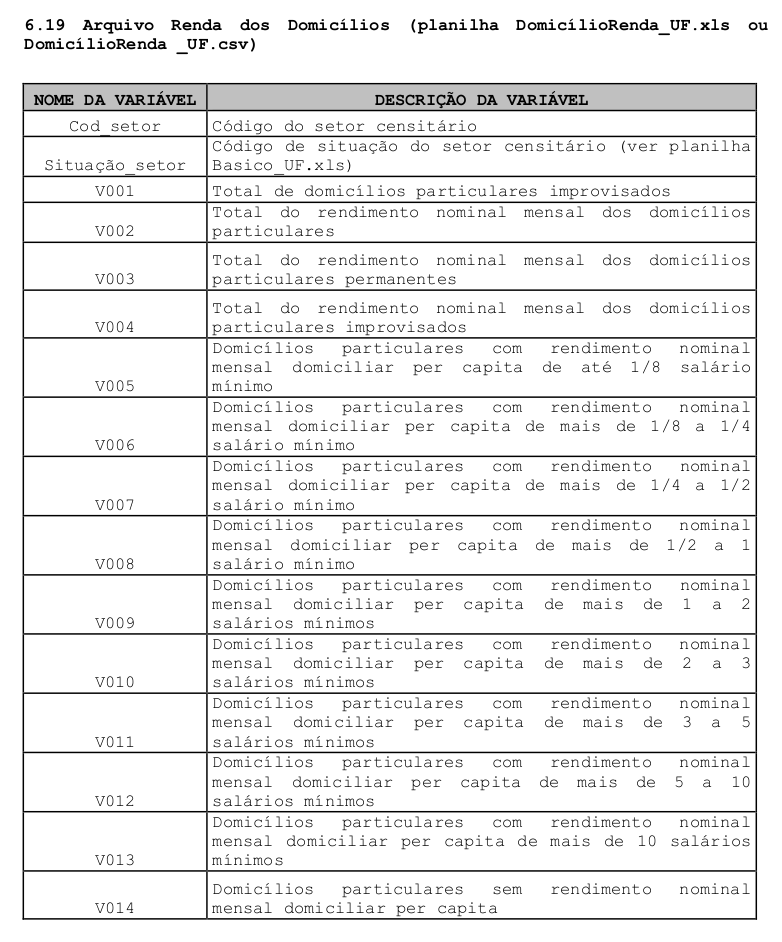

In [155]:
from IPython.display import Image
Image(filename='variaveis_censo_domicilio_renda.png') 

In [156]:
df_dom.dtypes

cod_setor         object
Situacao_setor     int64
V001              object
V002              object
V003              object
V004              object
V005              object
V006              object
V007              object
V008              object
V009              object
V010              object
V011              object
V012              object
V013              object
V014              object
dtype: object

In [157]:
def coerce_int(x):
    
    try:
        return int(x)
    except ValueError:
        return 0

In [158]:
for col in df_dom.columns:
    if col.startswith('V0'):
        df_dom[col] = df_dom[col].apply(coerce_int)

In [159]:
df_dom.fillna(0, inplace=True)

In [160]:
df_dom.dtypes

cod_setor         object
Situacao_setor     int64
V001               int64
V002               int64
V003               int64
V004               int64
V005               int64
V006               int64
V007               int64
V008               int64
V009               int64
V010               int64
V011               int64
V012               int64
V013               int64
V014               int64
dtype: object

In [161]:
df_dom['qtd_dom_menos_um_sm'] = df_dom['V005'] + df_dom['V006'] + df_dom['V007'] + df_dom['V008']
df_dom['qtd_dom_um_a_dez_sm'] = df_dom['V009'] + df_dom['V010'] + df_dom['V011'] + df_dom['V012']
df_dom['qtd_dom_mais_dez_sm'] = df_dom['V013']
df_dom['qtd_dom_improvisados'] = df_dom['V001']

In [162]:
cols_censo = [col for col in df_dom.columns
             if col.startswith('qtd')]

In [163]:
for col in cols_censo:
    print(col, df_dom[col].isnull().mean())

qtd_dom_menos_um_sm 0.0
qtd_dom_um_a_dez_sm 0.0
qtd_dom_mais_dez_sm 0.0
qtd_dom_improvisados 0.0


In [164]:
cols_censo.append('cod_setor')

In [165]:
df_dom = df_dom[cols_censo].copy()

In [166]:
df = pd.merge(df, df_dom, how='left', on='cod_setor')

In [167]:
df['qtd_dom_um_a_dez_sm'].isnull().any()

True

In [168]:
df['qtd_dom_um_a_dez_sm'].isnull().mean()

0.009259259259259259

In [169]:
df = df[df['qtd_dom_um_a_dez_sm'].notnull()].copy().reset_index(drop=True)

## DataFrame final

In [170]:
df.columns

Index(['cod_setor', 'ano_bo', 'rubrica', 'qtd_ocorr', 'setor_area',
       'setor_tipo', 'setor_pop', 'setor_ipvs', 'geometry', 'menor_dist_metro',
       'menor_dist_trem', 'a_500m_parque', 'a_500m_hosp', 'a_100m_escola',
       'qtd_dom_menos_um_sm', 'qtd_dom_um_a_dez_sm', 'qtd_dom_mais_dez_sm',
       'qtd_dom_improvisados'],
      dtype='object')

In [171]:
cols_modelagem = [
    'ano_bo', 
    'rubrica', 
    'qtd_ocorr', 
    'setor_area',
    'setor_tipo', 
    'setor_pop', 
    'setor_ipvs',
    'menor_dist_metro',
    'menor_dist_trem', 
    'a_500m_parque', 
    'a_500m_hosp', 
    #tem algo errado aqui
    #'a_100m_escola',
    'qtd_dom_menos_um_sm', 
    'qtd_dom_um_a_dez_sm', 
    'qtd_dom_mais_dez_sm',
    'qtd_dom_improvisados'
]

In [172]:
df_final = df[cols_modelagem].copy()

In [173]:
save_csv(df_final, 'df_final.csv')

In [174]:
df_final.dtypes

ano_bo                    int64
rubrica                  object
qtd_ocorr                 int64
setor_area              float64
setor_tipo               object
setor_pop               float64
setor_ipvs              float64
menor_dist_metro        float64
menor_dist_trem         float64
a_500m_parque              bool
a_500m_hosp                bool
qtd_dom_menos_um_sm     float64
qtd_dom_um_a_dez_sm     float64
qtd_dom_mais_dez_sm     float64
qtd_dom_improvisados    float64
dtype: object

In [175]:
for col in df_final.columns:
    if col.startswith('a_'):
        df_final[col] = df_final[col].apply(lambda x: 1 if x else 0)

In [176]:
df_final = pd.get_dummies(df_final, drop_first=True)

In [177]:
df_final.dtypes

ano_bo                    int64
qtd_ocorr                 int64
setor_area              float64
setor_pop               float64
setor_ipvs              float64
menor_dist_metro        float64
menor_dist_trem         float64
a_500m_parque             int64
a_500m_hosp               int64
qtd_dom_menos_um_sm     float64
qtd_dom_um_a_dez_sm     float64
qtd_dom_mais_dez_sm     float64
qtd_dom_improvisados    float64
rubrica_Roubo             uint8
setor_tipo_URBANO         uint8
dtype: object

In [178]:
df_final.rename({'rubrica_Roubo' : 'tipo_ocorr_roubo',
                'setor_tipo_URBANO' : 'setor_tipo_urbano'},
               axis=1, inplace=True)

In [179]:
save_csv(df_final, 'df_final_dummies.csv')

In [180]:
df_final

,ano_bo,qtd_ocorr,setor_area,setor_pop,setor_ipvs,menor_dist_metro,menor_dist_trem,a_500m_parque,a_500m_hosp,qtd_dom_menos_um_sm,qtd_dom_um_a_dez_sm,qtd_dom_mais_dez_sm,qtd_dom_improvisados,tipo_ocorr_roubo,setor_tipo_urbano
0,2018,1,57989.70,931.0,2.0,1325.312948,1460.339082,0,0,132.0,166.0,0.0,0.0,1,1
1,2021,1,57989.70,931.0,2.0,1325.312948,1460.339082,0,0,132.0,166.0,0.0,0.0,1,1
2,2017,1,14286.72,880.0,6.0,1487.731019,1546.421392,0,0,166.0,40.0,0.0,0.0,1,1
3,2018,1,14286.72,880.0,6.0,1487.731019,1546.421392,0,0,166.0,40.0,0.0,0.0,0,1
4,2019,1,14286.72,880.0,6.0,1487.731019,1546.421392,0,0,166.0,40.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308,2019,2,32031.72,565.0,2.0,1889.072574,3286.556283,0,1,67.0,117.0,0.0,0.0,1,1
6309,2020,1,32031.72,565.0,2.0,1889.072574,3286.556283,0,1,67.0,117.0,0.0,0.0,0,1
6310,2021,3,32031.72,565.0,2.0,1889.072574,3286.556283,0,1,67.0,117.0,0.0,0.0,0,1
6311,2017,1,21059.00,340.0,3.0,1979.947604,3680.418020,0,1,35.0,50.0,0.0,0.0,1,1


In [181]:
for col in df_final:
    print(col, df_final[col].isnull().sum())

ano_bo 0
qtd_ocorr 0
setor_area 0
setor_pop 0
setor_ipvs 0
menor_dist_metro 0
menor_dist_trem 0
a_500m_parque 0
a_500m_hosp 0
qtd_dom_menos_um_sm 0
qtd_dom_um_a_dez_sm 0
qtd_dom_mais_dez_sm 0
qtd_dom_improvisados 0
tipo_ocorr_roubo 0
setor_tipo_urbano 0


In [182]:
y = df_final['qtd_ocorr'].copy()
X = df_final.drop('qtd_ocorr', axis=1).copy()

In [183]:
X_names = X.columns

In [184]:
from sklearn.preprocessing import StandardScaler

In [185]:
scaler = StandardScaler()

In [186]:
X = scaler.fit_transform(X)

In [187]:
X = pd.DataFrame(X, columns= X_names)

<AxesSubplot:>

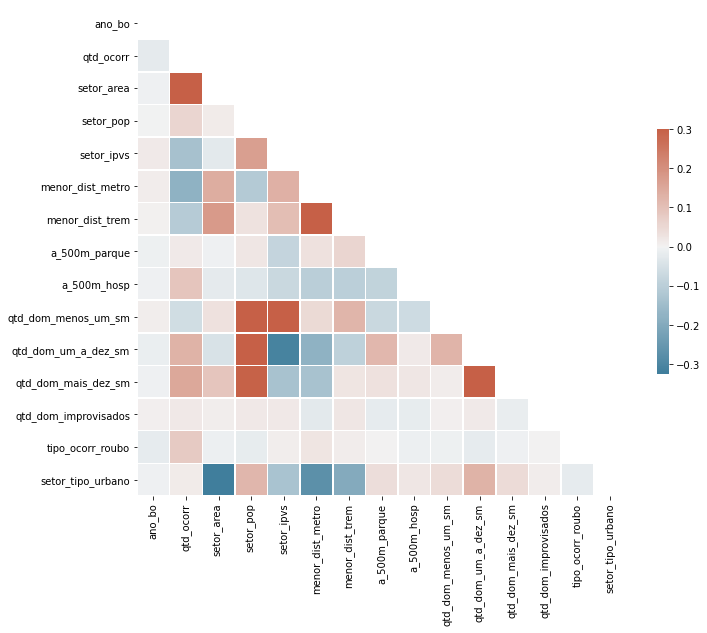

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_final.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [189]:
import statsmodels.api as sm

In [190]:
model = sm.OLS(y, X)

In [191]:
results = model.fit()

In [192]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              qtd_ocorr   R-squared (uncentered):                   0.132
Model:                            OLS   Adj. R-squared (uncentered):              0.130
Method:                 Least Squares   F-statistic:                              68.55
Date:                Sat, 26 Nov 2022   Prob (F-statistic):                   7.96e-182
Time:                        18:11:51   Log-Likelihood:                         -22681.
No. Observations:                6313   AIC:                                  4.539e+04
Df Residuals:                    6299   BIC:                                  4.548e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------